In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import Embedding, LSTM, Dropout, Dense, GRU, SimpleRNN, Flatten

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [110]:
df = pd.read_csv('../data/train.csv')

In [111]:
texts = df['text'].astype(str)
relevance = df['positive']
X_train, X_test, y_train, y_test = train_test_split(texts, relevance, test_size=0.15, random_state=42, shuffle=True)

In [112]:
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [113]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [114]:
# Padding
maxlen = 100 
X_train = pad_sequences(sequences_train, maxlen=maxlen)
y_train = np.array(y_train)

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(y_test)


In [115]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [96]:
for i in [X_train, X_val, y_train, y_val, X_test, y_test]:
    print(type(i))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Создадим функцию для тестирования моделей

In [117]:
def create_plot(history):
    plt.plot(
        history.history['loss'],
        label='Train loss'
        )
    plt.plot(
        history.history['val_loss'], 
        label='Val loss'
        )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.legend()
    plt.show()

def calculate_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Test accuracy is {}'.format(accuracy))
    print('Test precision is {}'.format(precision))
    print('Test recall is {}'.format(recall))
    print('Test f1 is {}'.format(f1))


def compile_fit_model(model, X_train, y_train, X_val, y_val):
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
        )
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        shuffle=False
        )
    return history

def test_model(model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """Trains and tests a given model.

    Args:
        model: The model to be trained and tested.
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        X_val: Validation features.
        y_val: Validation labels.
        threshold: Threshold for converting probabilities to binary predictions.

    Returns:
        None
    """
        
    history = compile_fit_model(model, X_train, y_train, X_val, y_val)
    create_plot(history)
    y_pred = model.predict(X_test)
    y_pred = (y_pred > threshold).astype(int)
    calculate_metrics(y_pred, y_test)



Попробуем сначала реализовать простую модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6445 - loss: 0.6312 - val_accuracy: 0.8510 - val_loss: 0.3604
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8733 - loss: 0.3132 - val_accuracy: 0.8585 - val_loss: 0.3329
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9226 - loss: 0.2151 - val_accuracy: 0.8504 - val_loss: 0.3455
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9607 - loss: 0.1386 - val_accuracy: 0.8428 - val_loss: 0.3703
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9866 - loss: 0.0802 - val_accuracy: 0.8372 - val_loss: 0.4021
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9967 - loss: 0.0440 - val_accuracy: 0.8347 - val_loss: 0.4395
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9990 - loss: 0.0244 - val_accuracy: 0.8344 - val_loss: 0.4743


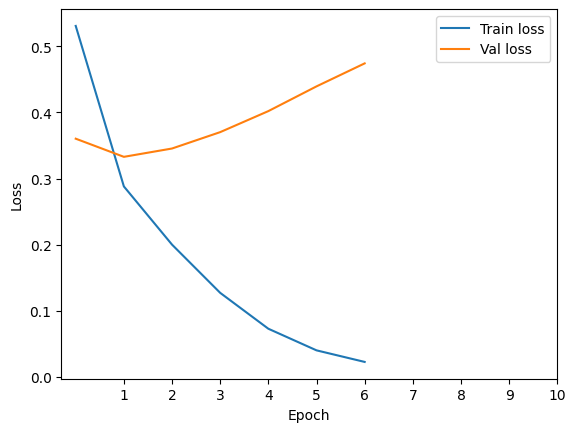

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8621333333333333
Test precision is 0.8525088697415104
Test recall is 0.8815513626834381
Test f1 is 0.8667869105900542


In [99]:
model_base = Sequential()
model_base.add(Embedding(max_words, 25))
model_base.add(Flatten())
model_base.add(Dense(1, activation='sigmoid'))

test_model(model_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает неплохое качество, при этом precision и recall довольно сбалансированы и близки друг к другу.

Попробуем далее усложнить модель.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6373 - loss: 0.6298 - val_accuracy: 0.8513 - val_loss: 0.3548
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8733 - loss: 0.3077 - val_accuracy: 0.8548 - val_loss: 0.3322
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9276 - loss: 0.2072 - val_accuracy: 0.8519 - val_loss: 0.3462
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9659 - loss: 0.1281 - val_accuracy: 0.8460 - val_loss: 0.3702
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9897 - loss: 0.0692 - val_accuracy: 0.8410 - val_loss: 0.4034
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9982 - loss: 0.0360 - val_accuracy: 0.8319 - val_loss: 0.4581
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9993 - loss: 0.0199 - val_accuracy: 0.8341 - val_loss: 0.4871


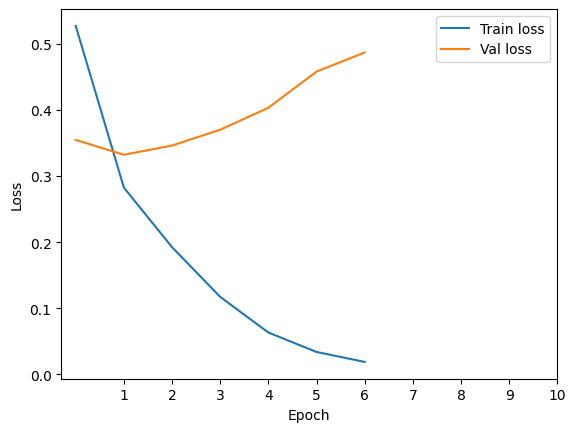

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8586666666666667
Test precision is 0.847979797979798
Test recall is 0.879979035639413
Test f1 is 0.8636831275720164


In [116]:
model_base2 = Sequential()
model_base2.add(Embedding(max_words, 30))
model_base2.add(Flatten())
model_base2.add(Dense(1, activation='sigmoid'))

test_model(model_base2, X_train, y_train, X_test, y_test, X_val, y_val)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6524 - loss: 0.6199 - val_accuracy: 0.8485 - val_loss: 0.3487
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8805 - loss: 0.2956 - val_accuracy: 0.8507 - val_loss: 0.3363
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9427 - loss: 0.1816 - val_accuracy: 0.8479 - val_loss: 0.3567
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9834 - loss: 0.0876 - val_accuracy: 0.8435 - val_loss: 0.3861
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9980 - loss: 0.0373 - val_accuracy: 0.8341 - val_loss: 0.4379


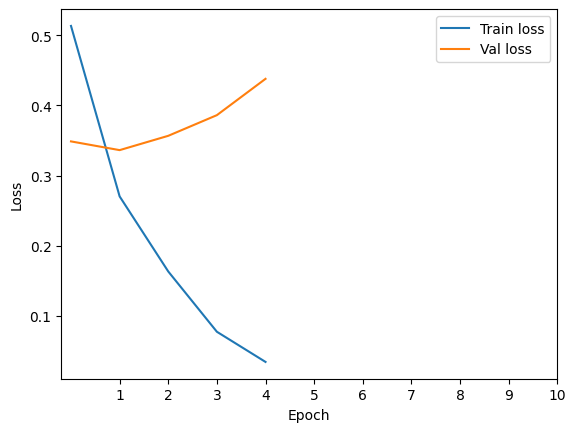

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8517333333333333
Test precision is 0.8414141414141414
Test recall is 0.8731656184486373
Test f1 is 0.8569958847736626


In [27]:
model_base3 = Sequential()
model_base3.add(Embedding(max_words, 45))
model_base3.add(Flatten())
model_base3.add(Dense(1, activation='sigmoid'))

test_model(model_base3, X_train, y_train, X_test, y_test, X_val, y_val)

По чистому f1 модель становится лучше, но присутствует дисбаланс в сторону recall

Попробуем рекурентные нейросети, которые часто хорошо подходят для классификации текстов.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5695 - loss: 0.6776 - val_accuracy: 0.7770 - val_loss: 0.4917
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8030 - loss: 0.4432 - val_accuracy: 0.8225 - val_loss: 0.4019
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8751 - loss: 0.3103 - val_accuracy: 0.8350 - val_loss: 0.3993
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9109 - loss: 0.2346 - val_accuracy: 0.8068 - val_loss: 0.4579
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9304 - loss: 0.1951 - val_accuracy: 0.8036 - val_loss: 0.5233


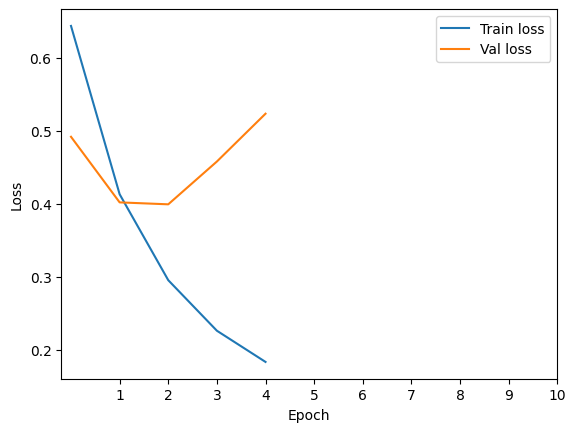

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.776
Test precision is 0.849476439790576
Test recall is 0.6802935010482181
Test f1 is 0.7555296856810246


In [19]:
model_rnn_base = Sequential()
model_rnn_base.add(Embedding(max_words, 15))
model_rnn_base.add(SimpleRNN(12))
model_rnn_base.add(Dense(1, activation='sigmoid'))

test_model(model_rnn_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель переобучилась и очевидно имеем наивный прогноз (всегда 1), отсюда высокий recall и низкий precision.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5382 - loss: 0.6811 - val_accuracy: 0.7698 - val_loss: 0.5005
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6437 - loss: 0.6588 - val_accuracy: 0.7299 - val_loss: 0.5968
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7927 - loss: 0.4695 - val_accuracy: 0.7832 - val_loss: 0.5101
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8476 - loss: 0.3731 - val_accuracy: 0.8212 - val_loss: 0.4535
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8810 - loss: 0.3087 - val_accuracy: 0.8181 - val_loss: 0.4475


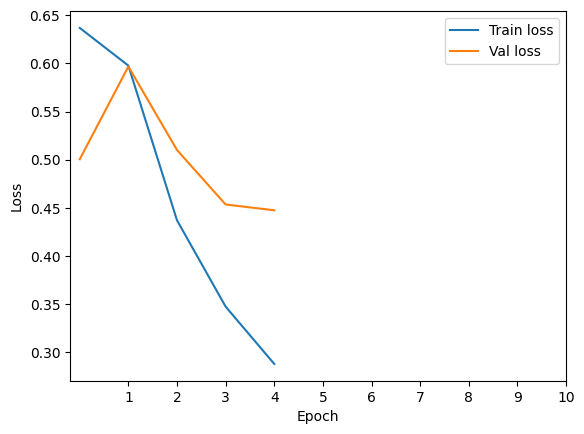

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.7674666666666666
Test precision is 0.7402597402597403
Test recall is 0.8364779874213837
Test f1 is 0.7854330708661418


In [20]:
model_rnn2 = Sequential()
model_rnn2.add(Embedding(max_words, 15))
model_rnn2.add(SimpleRNN(12))
model_rnn2.add(Dropout(0.25))
model_rnn2.add(Dense(1, activation='sigmoid'))

test_model(model_rnn2, X_train, y_train, X_test, y_test, X_val, y_val)

Дропаут слой сильно не помогает.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5888 - loss: 0.6613 - val_accuracy: 0.6945 - val_loss: 0.5934
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8004 - loss: 0.4648 - val_accuracy: 0.8206 - val_loss: 0.4159
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8458 - loss: 0.3777 - val_accuracy: 0.8300 - val_loss: 0.4109
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8905 - loss: 0.2955 - val_accuracy: 0.8228 - val_loss: 0.4236
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9173 - loss: 0.2405 - val_accuracy: 0.8005 - val_loss: 0.4894


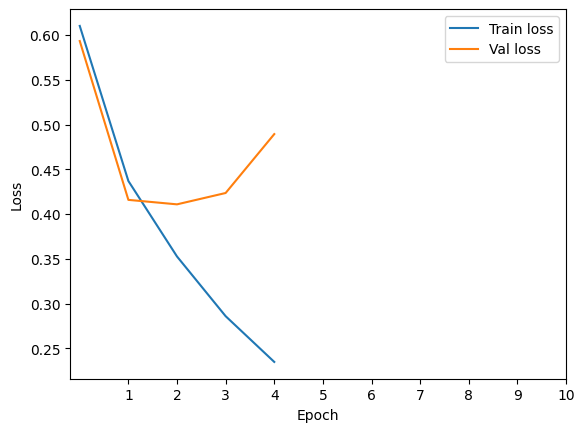

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.6768
Test precision is 0.8438735177865613
Test recall is 0.44758909853249473
Test f1 is 0.584931506849315


In [21]:
model_rnn3 = Sequential()
model_rnn3.add(Embedding(max_words, 15))
model_rnn3.add(SimpleRNN(12))
model_rnn3.add(Dropout(0.5))
model_rnn3.add(Dense(1, activation='sigmoid'))

test_model(model_rnn3, X_train, y_train, X_test, y_test, X_val, y_val)

Попробуем модель GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5890 - loss: 0.6493 - val_accuracy: 0.7472 - val_loss: 0.4971
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.8345 - loss: 0.4012 - val_accuracy: 0.8394 - val_loss: 0.3734
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.8810 - loss: 0.3143 - val_accuracy: 0.8457 - val_loss: 0.3780
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9012 - loss: 0.2734 - val_accuracy: 0.8422 - val_loss: 0.3911
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9164 - loss: 0.2495 - val_accuracy: 0.8375 - val_loss: 0.4141


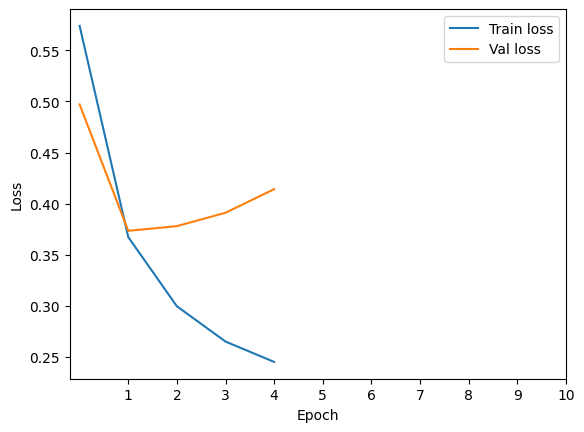

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test accuracy is 0.7424
Test precision is 0.9297445255474452
Test recall is 0.5340670859538784
Test f1 is 0.6784287616511319


In [22]:
model_gru_base = Sequential()
model_gru_base.add(Embedding(max_words, 15))
model_gru_base.add(GRU(12))
model_gru_base.add(Dropout(0.5))
model_gru_base.add(Dense(1, activation='sigmoid'))

test_model(model_gru_base, X_train, y_train, X_test, y_test, X_val, y_val)

Баланс precision и recall есть, но f1 ниже чем базовая простая модель.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6914 - loss: 0.5697 - val_accuracy: 0.8538 - val_loss: 0.3619
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8697 - loss: 0.3158 - val_accuracy: 0.8479 - val_loss: 0.3517
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9038 - loss: 0.2545 - val_accuracy: 0.8450 - val_loss: 0.3696
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9211 - loss: 0.2177 - val_accuracy: 0.8438 - val_loss: 0.4091
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9260 - loss: 0.1978 - val_accuracy: 0.8369 - val_loss: 0.4263


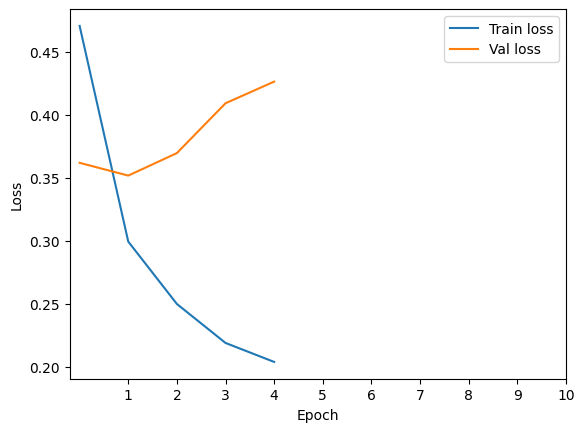

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test accuracy is 0.8506666666666667
Test precision is 0.8703296703296703
Test recall is 0.8301886792452831
Test f1 is 0.849785407725322


In [23]:
model_lstm_base = Sequential()
model_lstm_base.add(Embedding(max_words, 15))
model_lstm_base.add(LSTM(12))
model_lstm_base.add(Dense(1, activation='sigmoid'))

test_model(model_lstm_base, X_train, y_train, X_test, y_test, X_val, y_val)

Ситуация аналогична GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6861 - loss: 0.5783 - val_accuracy: 0.8432 - val_loss: 0.3692
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8645 - loss: 0.3256 - val_accuracy: 0.8435 - val_loss: 0.3597
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9026 - loss: 0.2572 - val_accuracy: 0.8366 - val_loss: 0.3783
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9225 - loss: 0.2142 - val_accuracy: 0.8366 - val_loss: 0.4091
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9286 - loss: 0.1975 - val_accuracy: 0.8369 - val_loss: 0.4259


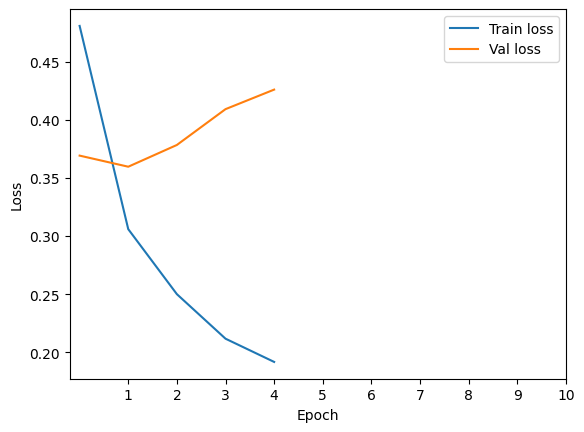

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test accuracy is 0.8485333333333334
Test precision is 0.8432377049180327
Test recall is 0.8626834381551363
Test f1 is 0.8528497409326424


In [24]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(max_words, 15))
model_lstm2.add(LSTM(6))
model_lstm2.add(Dense(1, activation='sigmoid'))

test_model(model_lstm2, X_train, y_train, X_test, y_test, X_val, y_val)

Снижение числа нейронов слоя LSTM не дает нужного эффекта, модель хуже чем базовая, однако обучается дольше.

Попробуем несколько слоев LSTM

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.6735 - loss: 0.5839 - val_accuracy: 0.8338 - val_loss: 0.3884
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.8663 - loss: 0.3426 - val_accuracy: 0.8444 - val_loss: 0.3684
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.9029 - loss: 0.2676 - val_accuracy: 0.8403 - val_loss: 0.3981
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.9227 - loss: 0.2214 - val_accuracy: 0.8350 - val_loss: 0.4391
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.9343 - loss: 0.1939 - val_accuracy: 0.8363 - val_loss: 0.4532


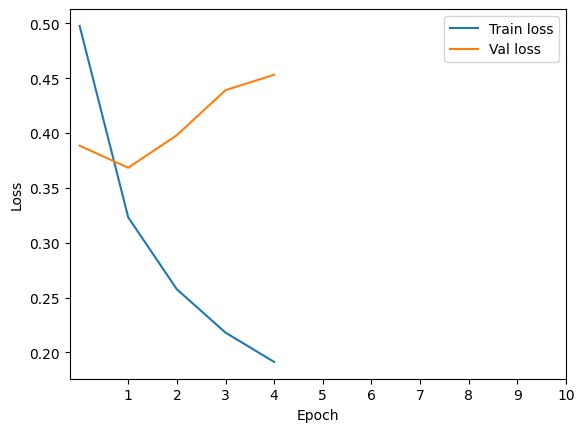

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Test accuracy is 0.8493333333333334
Test precision is 0.8551031200423057
Test recall is 0.8474842767295597
Test f1 is 0.8512766517504606


In [25]:
model_lstm3 = Sequential()
model_lstm3.add(Embedding(max_words, 30))
model_lstm3.add(LSTM(6, return_sequences=True))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(LSTM(6))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(1, activation='sigmoid'))

test_model(model_lstm3, X_train, y_train, X_test, y_test, X_val, y_val)

Качество выросло незаметно

Попробуем полносвязную нейросеть

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5418 - loss: 0.6806 - val_accuracy: 0.8290 - val_loss: 0.4385
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8009 - loss: 0.4724 - val_accuracy: 0.8193 - val_loss: 0.3975
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8810 - loss: 0.3452 - val_accuracy: 0.8297 - val_loss: 0.3946
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9237 - loss: 0.2431 - val_accuracy: 0.8225 - val_loss: 0.5268
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9463 - loss: 0.1795 - val_accuracy: 0.8297 - val_loss: 0.5768


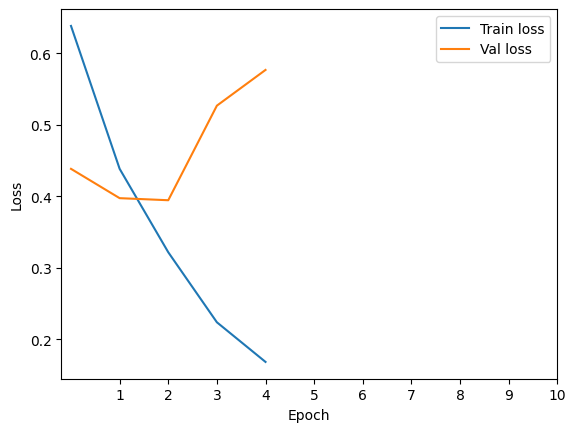

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8192
Test precision is 0.8324324324324325
Test recall is 0.8071278825995807
Test f1 is 0.8195848855774348


In [26]:
model_fully = Sequential()
model_fully.add(Embedding(max_words, 30))
model_fully.add(Flatten())
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(1, activation='sigmoid'))

test_model(model_fully, X_train, y_train, X_test, y_test, X_val, y_val)

Переобучение и наивный прогноз

Проведем кросс валидацию базовой модели.
Легко можем себе это позволить, так как модель простая и учится очень быстро.
А если можем себе позволить, то почему бы и не сделать.

In [67]:
def cross_validate(
        model, X, y,
        loss_function = 'binary_crossentropy', 
        threshold=0.5, no_epochs=10,
        batch_size=32, max_words=5000,
        optimizer='adam'
        
        ) -> None:

    """
    Performs 5-fold cross-validation for a classification model, using embedding for text vectorization.

    Args:
        model: The classification model to be trained.
        X_train: Array of training data (text data).
        X_test: Array of test data (text data).
        y_train: Vector of class labels for the training data.
        y_test: Vector of class labels for the test data.

    Returns:
        None. Prints the cross-validation results to the console.
    """

    # Define per-fold score containers
    f1_per_fold = []
    accuracy_per_fold = []
    recall_score_per_fold = []
    precison_score_per_fold = []

    # Merge inputs and targets
    inputs = np.array(X)
    targets = np.array(y)

    # Define the K-fold Cross Validator
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(inputs[train])
        sequences_train = tokenizer.texts_to_sequences(inputs[train])
        sequences_test = tokenizer.texts_to_sequences(inputs[test])
        
        X_train = pad_sequences(sequences_train, maxlen=maxlen)
        y_train = np.array(targets[train])

        X_test = pad_sequences(sequences_test, maxlen=maxlen)
        y_test = np.array(targets[test])

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

        # Compile the model
        model.compile(
            loss=loss_function,
            optimizer=optimizer,
            metrics=['accuracy']
            )

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        model.fit(
            X_train, y_train,
            epochs=no_epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val),
            shuffle=False
            )

        # Generate generalization metrics
        y_pred = model.predict(X_test)
        y_pred = (y_pred > threshold).astype(int)
        
        accuracy_per_fold.append(accuracy_score(y_test, y_pred))
        f1_per_fold.append(f1_score(y_test, y_pred))
        precison_score_per_fold.append(precision_score(y_test, y_pred))
        recall_score_per_fold.append(recall_score(y_test, y_pred))
        
        # Increase fold number
        fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(f1_per_fold)):
        print('------------------------------------------------------------------------')
        print(
            f'''
            > Fold {i+1}
            - F1: {f1_per_fold[i]}
            - Precision: {precison_score_per_fold[i]}
            - Recall: {recall_score_per_fold[i]}
            ''')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
    print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
    print(f'> Precision: {np.mean(precison_score_per_fold)} (+- {np.std(precison_score_per_fold)})')
    print(f'> Recall: {np.mean(recall_score_per_fold)} (+- {np.std(recall_score_per_fold)})')
    print('------------------------------------------------------------------------')

In [68]:
df_train = pd.read_csv('../data/train.csv')
texts_train = df_train['text'].astype(str)
labels_train = df_train['positive']

In [61]:
model = Sequential()
model.add(Embedding(max_words, 45))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

cross_validate(
    model, texts_train, labels_train,
    max_words=5000
    )

model.summary()


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6277 - loss: 0.6298 - val_accuracy: 0.8443 - val_loss: 0.3546
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8839 - loss: 0.2958 - val_accuracy: 0.8547 - val_loss: 0.3287
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9434 - loss: 0.1812 - val_accuracy: 0.8507 - val_loss: 0.3468
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9854 - loss: 0.0886 - val_accuracy: 0.8483 - val_loss: 0.3826
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9982 - loss: 0.0383 - val_accuracy: 0.8447 - val_loss: 0.4143
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0185 - val_accuracy: 0.8400 - val_loss: 0.4670
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9996 - loss: 0.0107 - val_accuracy: 0.8343 - val_loss: 0.5376
157/157

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 45)        │       225,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │         4,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,505 (2.63 MB)

 Trainable params: 229,501 (896.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 459,004 (1.75 MB)

In [118]:
df_test = pd.read_csv('../data/train.csv')

In [119]:
texts_test = df_test['text'].astype(str)
labels_test = df_test['positive']

In [120]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(labels_test)

In [124]:
y_pred = model_base2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [125]:
calculate_metrics(y_pred, y_test)

Test accuracy is 0.60108
Test precision is 0.6023823028927964
Test recall is 0.59472
Test f1 is 0.5985266293627471


F1 очень близок с лучшей моделью из классических, модель более менее балансирована по precision и recall. Recall выше, что отлично подходит для нашей задачи.

В итоге наилучшей моделью оказалась простая модель нейросети, состоящая из слоя эмбеддинга и выходного слоя.
Эта модель показывает очень близкое качество с моделью из файла с классическими методами, однако в случае нейросети модель обучается в разы быстрее, а значит она подходит лучше для нашей задачи.